In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
%matplotlib inline
%config InlineBackend.figure_format='retina'
import cmocean
import cartopy.crs as ccrs
import matplotlib.path as mpath
import nc_time_axis
import pandas as pd
import matplotlib as mpl
import momlevel as ml
import gcsfs
import zarr
from matplotlib.ticker import FormatStrFormatter

In [3]:
def south_pole_map(cols=1, rows=1, fig_size=(12,8), max_extent=-50, facecolor='white'):
    ''' 
    User note: In order to call the function, begin cell with: fig, ax = south_pole_map(**args).
    
    Neglecting "fig, ax =" at the begeinning will not map your data to the existing axes.
    
    This function sets up a polar projection centered at the South Pole, which DataArrays can be plotted over.
    
    Optional arguments accepted for figure size, maximum (northward) extent and facecolor. Any number of columns and/or rows are also accepted for multiple subplots.
    
    If creating multiple subplots, ax=ax[*index*] must be passed in the plot call for each array.
    
    By default, these are set to (12,8), -50ºS and gray, respectively. Columns/Rows set to 1 by default – specifying axes in which to plot data is not necessary when using default column number.
    '''
    import matplotlib.path as mpath
    import numpy as np
    import cartopy.crs as ccrs
    
    fig,ax = plt.subplots(figsize=fig_size, ncols=cols, nrows=rows, subplot_kw={'projection': ccrs.SouthPolarStereo(), 'facecolor':facecolor}, layout='constrained')

    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    if rows>1 and cols>1:
        for i in range(rows):
            for j in range(cols):
                ax[i,j].set_boundary(circle, transform=ax[i,j].transAxes)

                # lat/long map extents. shows south pole out to 50ºS
                ax[i,j].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif cols>1 and rows==1:
        for i in range(cols):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    elif rows>1 and cols==1:
        for i in range(rows):
            ax[i].set_boundary(circle, transform=ax[i].transAxes)

            # lat/long map extents. shows south pole out to 50ºS
            ax[i].set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    else:
        ax.set_boundary(circle, transform=ax.transAxes)

            # lat/long map extents. shows south pole out to 50ºS
        ax.set_extent([-180, 180, -90, max_extent], ccrs.PlateCarree())
    
    
    #must return fig, ax when creating multiple subplots in a function
    return fig, ax

In [4]:
mask_CM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/CM4_mask_antarctica.nc')
mask_ESM4= xr.open_dataset('/home/pachamama/shared/antarctica_mask/ESM4_mask_antarctica.nc')

In [5]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


In [6]:
gfdl_esm4_precip_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Amon' & \
    variable_id == 'pr' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr1' & \
    member_id == 'r1i1p1f1'"
)

In [7]:
gfdl_cm4_precip_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Amon' & \
    variable_id == 'pr' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-CM4' & \
    grid_label == 'gr1' & \
    member_id == 'r1i1p1f1'"
)

In [8]:
gfdl_esm4_precip_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
18988,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701


In [9]:
gfdl_cm4_precip_data

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2471,ScenarioMIP,NOAA-GFDL,GFDL-CM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-CM...,NaN,20180701


In [10]:
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = gfdl_cm4_precip_data.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

precip_cm4 = xr.open_zarr(mapper, consolidated=True)
precip_cm4

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            pr
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-08-13;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/06d6927b-c820-432b-855b-35f5e60946c3
    version_id:             v20180701

In [11]:
gcs = gcsfs.GCSFileSystem(token='anon')
zstore = gfdl_esm4_precip_data.zstore.values[-1]
mapper = gcs.get_mapper(zstore)

precip_esm4 = xr.open_zarr(mapper, consolidated=True)
precip_esm4

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 288, time: 1032)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
  * lon        (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(1032, 2), meta=np.ndarray>
Data variables:
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    comment:                <null ref>
    ...                     ...
    variable_id:            pr
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/f0170c19-0300-497d-a8d3-9699e4a0f88e
    version_id:             v20180701

In [12]:
ESM4_pr= precip_esm4.pr
CM4_pr=precip_cm4.pr

In [13]:
ESM4_pr

<xarray.DataArray 'pr' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-pr, shape=(1032, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

In [14]:
CM4_pr

<xarray.DataArray 'pr' (time: 1032, lat: 180, lon: 288)>
dask.array<open_dataset-pr, shape=(1032, 180, 288), dtype=float32, chunksize=(600, 180, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order1
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          kg m-2 s-1

In [74]:
precip_total_CM4=CM4_pr.mean('time')
precip_total_ESM4=ESM4_pr.mean('time')

In [83]:

plateau_precip_CM4_bar=(precip_total_CM4*(mask_CM4.plateau_CM4)).mean('lat').mean('lon')*(10E6)
ross_precip_CM4_bar=(precip_total_CM4*(mask_CM4.ross_CM4)).mean('lat').mean('lon')*(10E6)
lowwest_precip_CM4_bar=(precip_total_CM4*(mask_CM4.lowwest_CM4)).mean('lat').mean('lon')*(10E6)
loweast_precip_CM4_bar=(precip_total_CM4*(mask_CM4.loweast_CM4)).mean('lat').mean('lon')*(10E5)
filchner_precip_CM4_bar=(precip_total_CM4*(mask_CM4.filchner_CM4)).mean('lat').mean('lon')*(10E6)
peninsula_precip_CM4_bar=(precip_total_CM4*(mask_CM4.peninsula_CM4)).mean('lat').mean('lon')*(10E5)

In [84]:
plateau_precip_ESM4_bar=((precip_total_ESM4*(mask_ESM4.plateau_ESM4)).mean('lat').mean('lon'))*(10E6)
ross_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.ross_ESM4)).mean('lat').mean('lon')*(10E6)
lowwest_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.lowwest_ESM4)).mean('lat').mean('lon')*(10E6)
loweast_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.loweast_ESM4)).mean('lat').mean('lon')*(10E5)
filchner_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.filchner_ESM4)).mean('lat').mean('lon')*(10E6)
peninsula_precip_ESM4_bar=(precip_total_ESM4*(mask_ESM4.peninsula_ESM4)).mean('lat').mean('lon')*(10E5)

In [85]:
plat_value_ESM4=print(plateau_precip_ESM4_bar.values)
ross_value_ESM4= print(ross_precip_ESM4_bar.values)
west_value_ESM4=print(lowwest_precip_ESM4_bar.values)
east_value_ESM4=print(loweast_precip_ESM4_bar.values)
filch_value_ESM4=print(filchner_precip_ESM4_bar.values)
pen_value_ESM4=print(peninsula_precip_ESM4_bar.values)

21.90448
66.328094
85.67833
10.615166
78.22157
27.864498


In [86]:
plat_value_CM4=print(plateau_precip_CM4_bar.values)
ross_value_CM4= print(ross_precip_CM4_bar.values)
west_value_CM4=print(lowwest_precip_CM4_bar.values)
east_value_CM4=print(loweast_precip_CM4_bar.values)
filch_value_CM4=print(filchner_precip_CM4_bar.values)
pen_value_CM4=print(peninsula_precip_CM4_bar.values)

19.561344
66.657684
66.62609
10.162506
71.13808
26.725796


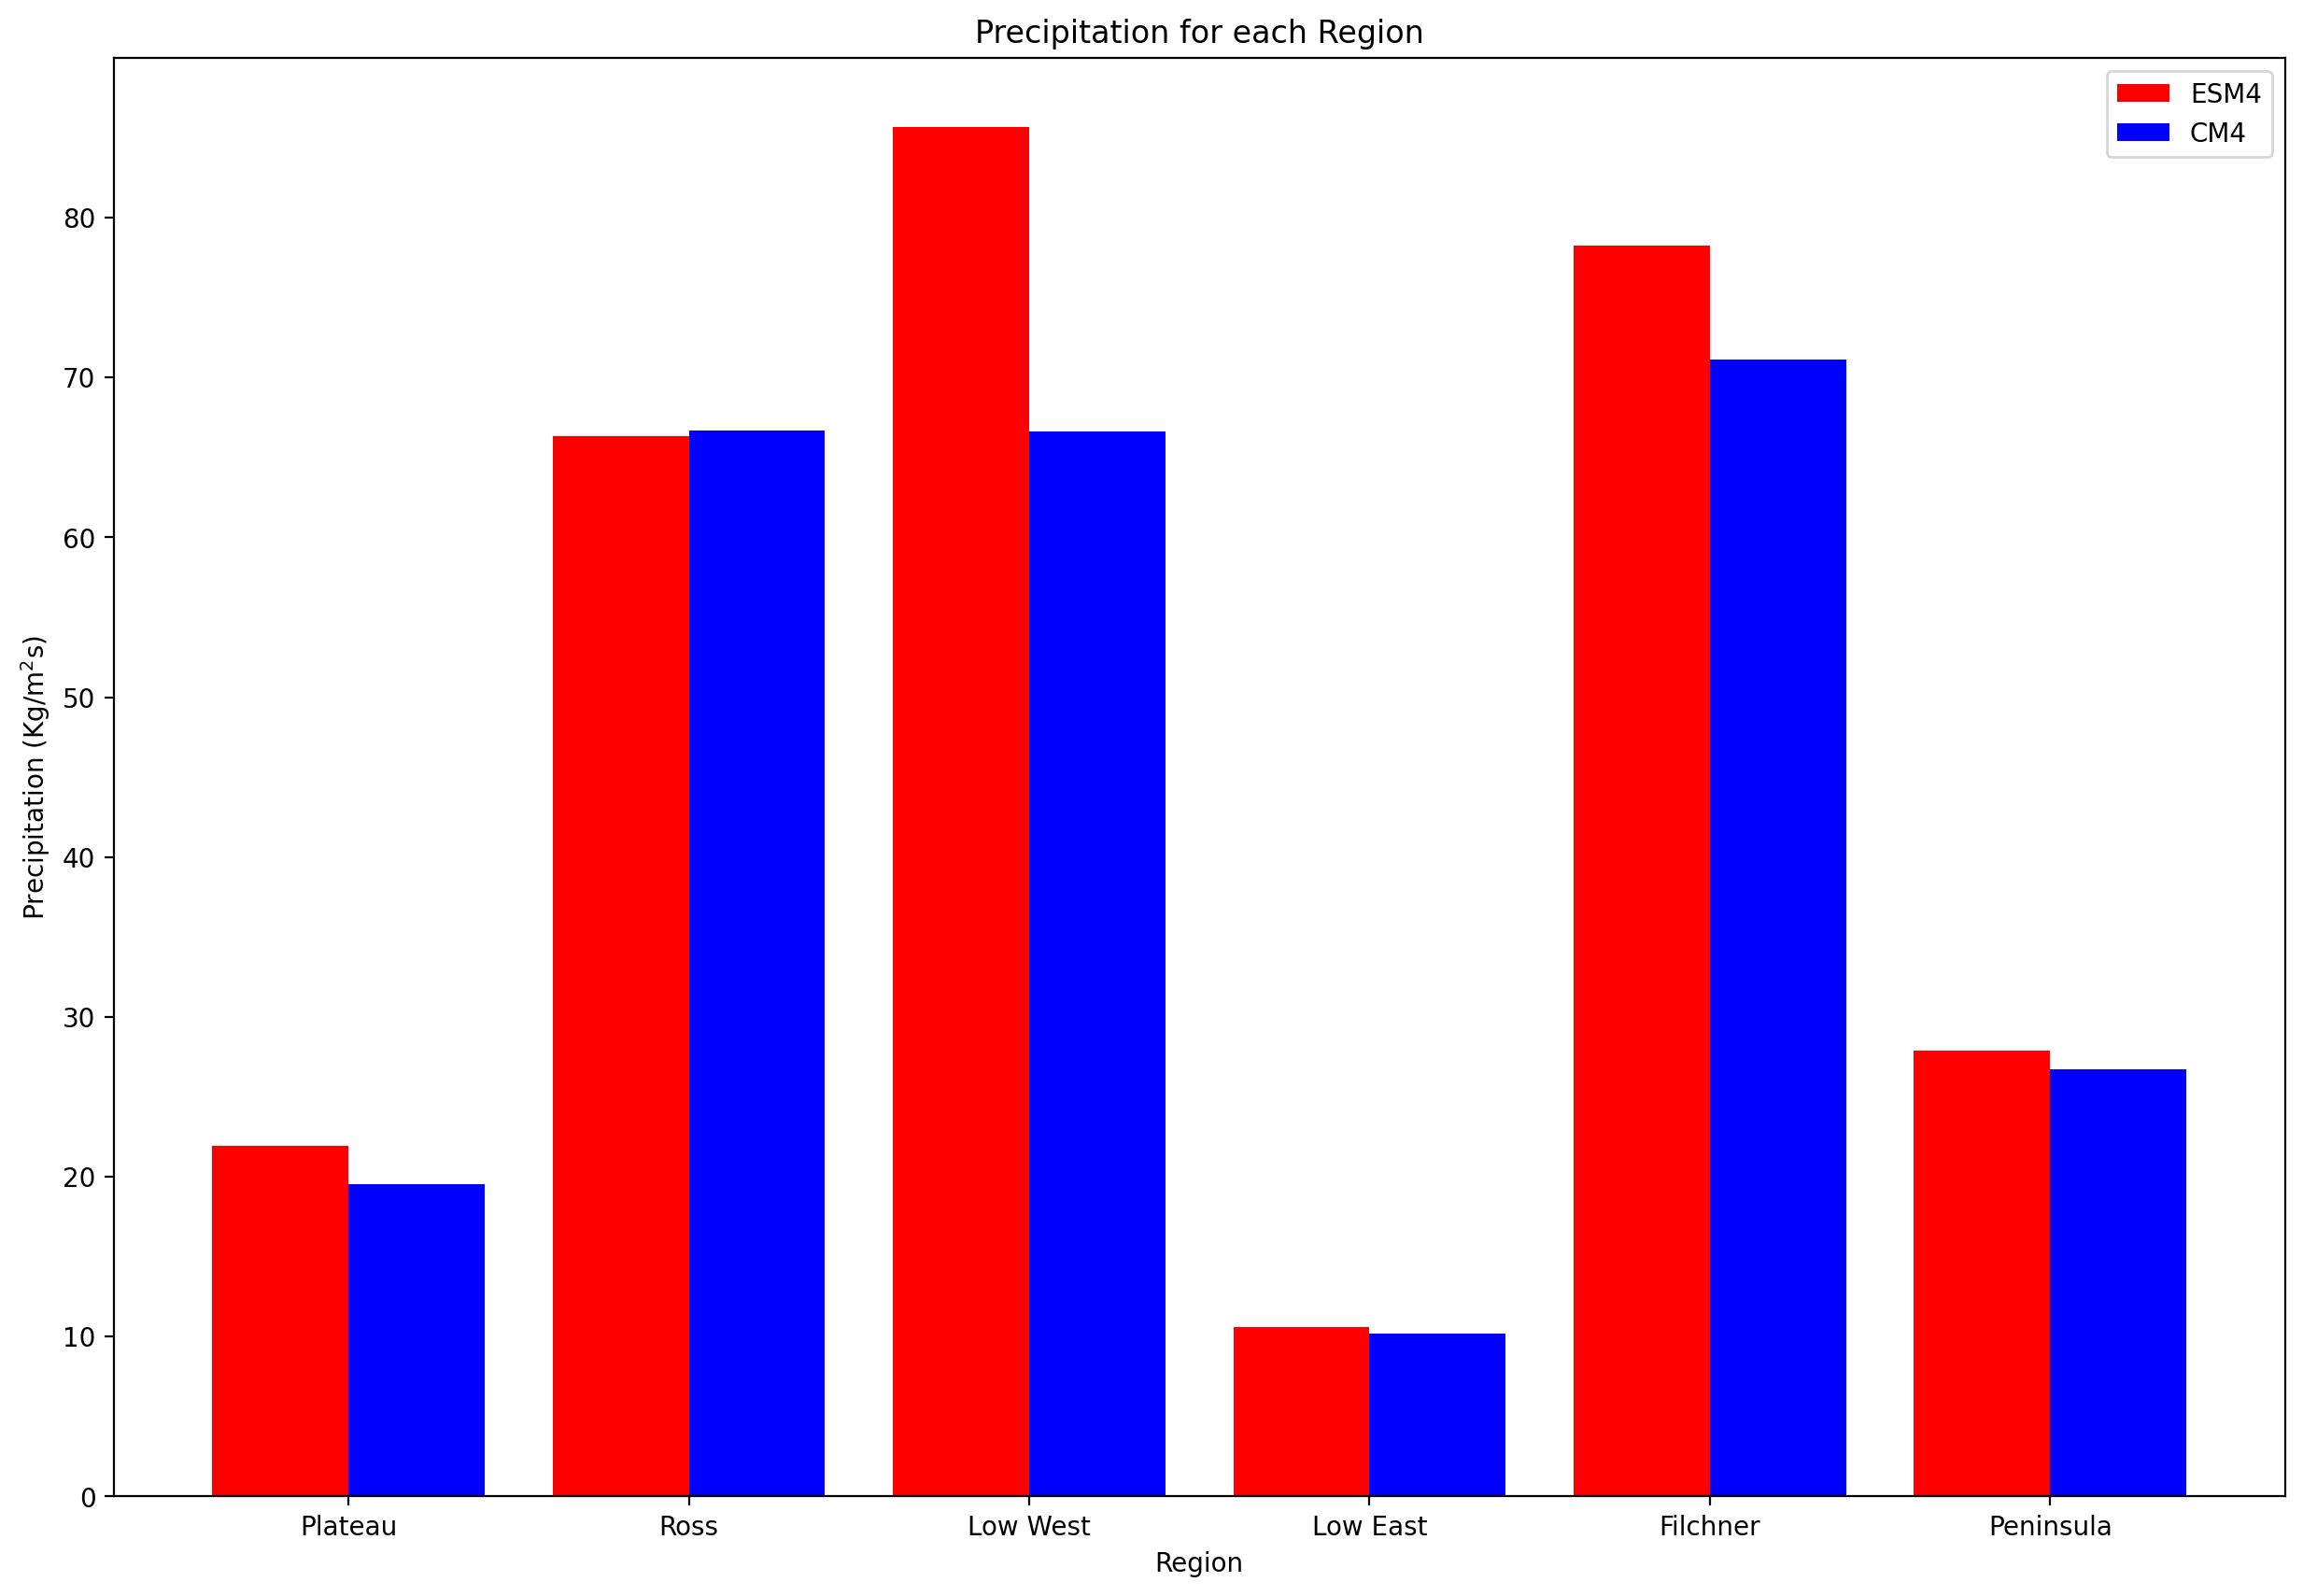

In [87]:

fig, ax= plt.subplots(figsize= (15,10))

X = ['Plateau','Ross','Low West','Low East', 'Filchner', 'Peninsula'] 
CM4 = [19.561344,
66.657684,
66.62609,
10.162506,
71.13808,
26.725796] 
ESM4 = [21.90448,
66.328094,
85.67833,
10.615166,
78.22157,
27.864498] 
  
X_axis = np.arange(len(X)) 
  
plt.bar(X_axis - 0.2, ESM4, 0.4, label = 'ESM4', color='r') 
plt.bar(X_axis + 0.2, CM4, 0.4, label = 'CM4', color= 'blue') 
  
plt.xticks(X_axis, X) 
plt.xlabel("Region") 
plt.ylabel("Precipitation (Kg/m$^2$s)" )
plt.title("Precipitation for each Region") 
plt.legend() 

plt.show() 